# Stock Screener

### This notebook is intended to help get a centralized view of important statistics for stocks of companies.

### 1. Imports
We begin with all the imports we will need for analysis.

In [17]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import math
import json

### 2. Getting tickers for gold stocks.

In [18]:
#Where tickers comes from
goldStocksUrl = "http://www.miningfeeds.com/gold-mining-report-all-countries"

def goldStockParser(url, tickerColumn, stockTypes):
    """Goes to url above and pulls the tickers of each 
       gold mining company, dumps them in a pickle file 
       and returns the tickers as a list."""
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "lxml")
    table = soup.find("table")
    tickers = []
    for row in table.findAll("tr")[1:]:
        ticker = row.findAll("td")[tickerColumn].text
        #Randgold real ticker.
        if (ticker == "GOLD.L"):
            ticker = "GOLD"
        tickers.append(ticker)

    with open(stockTypes + ".pickle", "wb") as file:
        pickle.dump(tickers, file)

    return tickers

def pickleLoader(stockTypes):
    """Loads tickers from a pickle file and returns them as a list."""
    with open(stockTypes + ".pickle", "rb") as file:
        return pickle.load(file)

#Look in cache if False, go to website if true.    
reloadGoldTickers = False

badDataStocks = ["GLF.AX", "AZ.TO", "LEX.TO", "RN.TO", "P.TO", "CSQ.V",
                 "DNA.TO", "PRH.AX", "GBU.TO", "RPM.V", "ARZ.TO", "ABU.AX",
                 "BAA.TO",]
goldStockTickers = []

if reloadGoldTickers:
    goldStockTickers = goldStockParser(goldStocksUrl, 2, "goldStocks")
else:
    goldStockTickers = pickleLoader("goldStocks")

#Remove stocks with bad data.    
for ticker in badDataStocks:
    goldStockTickers.remove(ticker)
    
print(goldStockTickers)

['NEM', 'ABX', 'FNV.TO', 'NCM.AX', 'GG', 'AEM', 'KGC', 'RGLD', 'RRS.L', 'FRES.L', 'AGG.AX', 'EVN.AX', 'GFI', 'BTO.TO', 'YRI.TO', 'IMG.TO', 'AGI.TO', 'CEY.L', 'PVG', 'DGC.TO', 'NGD.TO', 'RRL.AX', 'OGC.TO', 'SBM.AX', 'CG.TO', 'EDV.TO', 'NG.TO', 'ELD.TO', 'SAR.AX', 'SMF.TO', 'HMY', 'TXG.TO', 'CGG.TO', 'NSU.TO', 'GUY.TO', 'RSG.AX', 'SEA.TO', 'MUX', 'RIC', 'PG.TO', 'OSK.TO', 'ALIAF', 'CNL.TO', 'GOR.AX', 'POG.L', 'GSS', 'PAF.L', 'AR.TO', 'PRU.AX', 'TBR.AX', 'BGM.V', 'TGZ.TO', 'SBB.TO', 'GORO', 'WDO.TO', 'HRT.TO', 'WAF.AX', 'VIT.V', 'AOT.V', 'NGQ.TO', 'BDR.AX', 'HUM.L', 'RMS.AX', 'SLR.AX', 'BSX.TO', 'GCY.AX', 'KOR.TO', 'MOZ.TO', 'BTR.V', 'HRR.AX', 'PRB.V', 'ALK.AX', 'HAS.AX', 'R.TO', 'JAG.TO', 'MAX.TO', 'TNG.AX', 'PEN.AX', 'CAL.TO', 'TLG.AX', 'RUP.V', 'GGP.L', 'AAL.V', 'KCN.AX', 'ITH.TO', 'MML.AX', 'GGG.AX', 'VGZ', 'ARU.V', 'RMX.TO', 'QBL.AX', 'TSG.L', 'ATC.V', 'KGL.AX', 'TML.TO', 'IMA.AX', 'DRM.AX', 'RED.AX', 'MTO.V', 'DGR.AX', 'MRC.AX', 'DNG.TO', 'LIO.V', 'GME.AX', 'LEG.AX', 'BAR.TO', 'ATM.

### 3. Specify formatting details of data.

Specify rows of data that are wanted from yahoo.

Specify rows of data that have letters in their numbers for conversion.

Specify rows of data that have percentage signs in their numbers for conversion.

In [19]:
wantedRows = {0  : "marketCap", 
              1  : "enterpriseValue",
              2  : "trailingPe",
              3  : "forwardPe",
              4  : "5YrPeg",
              5  : "priceSales",
              6  : "priceBook",
              7  : "evSales",
              8  : "evEBITDA",
              11 : "profitMargin",
              12 : "operatingMargin",
              13 : "returnOnAssets",
              14 : "returnOnEquity",
              15 : "revenue",
              16 : "revenuePerShare",
              17 : "quarterlyRevenueGrowth",
              18 : "grossProfit",
              19 : "EBITDA",
              20 : "netIncomeForCommon",
              21 : "Diluted EPS",
              22 : "quarterlyEarningsGrowth",
              23 : "totalCash",
              24 : "cashPerShare",
              25 : "totalDebt",
              26 : "debtEquity",
              27 : "currentRatio",
              28 : "bookValuePerShare", 
              29 : "operatingCashFlow",
              30 : "leveredFreeCashFlow",
              31 : "beta3YrMonthly",
              32 : "52WeekChange",
              33 : "spy52WeekChange",
              34 : "52WeekHigh",
              35 : "52WeekLow",
              36 : "50dayMvAvg",
              37 : "200dayMvAvg",
              38 : "avg3MonthVol",
              39 : "avg10DayVol",
              40 : "sharesOutstanding",
              41 : "sharesFloating",
              42 : "heldByInsiders",
              43 : "heldByInstitutions",
              44 : "sharesShort1MonthPrior",
              45 : "shortRatio",
              46 : "shortToFloat",
              47 : "shortToOutstanding",
              48 : "sharesShort2MonthsPrior",
              49 : "forwardDividendRate",
              50 : "forwardDividendYield",
              51 : "trailingDividendRate",
              52 : "trailingDividendYield",
              53 : "5yrAvgDividendYield",
              54 : "payoutRatio",
              55 : "dividendDate",
              56 : "exDividendDate",
              57 : "lastSplitFactorNewPerOld",
              58 : "lastSplitDate",
              60 : "currentPrice",}

letterNumbers = ["marketCap", 
                 "enterpriseValue",
                 "revenue",
                 "grossProfit",
                 "EBITDA",
                 "netIncomeForCommon",
                 "totalCash",
                 "totalDebt",
                 "operatingCashFlow",
                 "leveredFreeCashFlow",
                 "avg3MonthVol",
                 "avg10DayVol",
                 "sharesOutstanding",
                 "sharesFloating",
                 "sharesShort1MonthPrior",
                 "sharesShort2MonthsPrior",]

percentageNumbers = ["profitMargin",
                     "operatingMargin",
                     "returnOnAssets",
                     "returnOnEquity",
                     "quarterlyRevenueGrowth",
                     "quarterlyEarningsGrowth",
                     "52WeekChange",
                     "spy52WeekChange",
                     "heldByInsiders",
                     "heldByInstitutions",
                     "shortToFloat",
                     "shortToOutstanding",
                     "forwardDividendYield",
                     "trailingDividendYield",
                     "payoutRatio",]


### 4. Retreive data from yahoo and cache it.
We need to look up data from yahoo and store it in a csv locally for caching purposes. Also want to format well. ie remove redundant columns and rename.

In [20]:
baseurl = "https://uk.finance.yahoo.com/quote/"

def getDataFromYahoo(stockTypes, tickers, baseurl = baseurl):
    """Checks if data has been stored in csv, if not
       looks to yahoo. Then returns as map of tickers to dataframe."""
    #Create directory for data of tickers.
    dataDir = "./%s_data" % stockTypes
    createDirIfItDoesntExist(dataDir)
    
    frames = {}
    
    for ticker in tickers:
        dataFile = "./%s/%s.csv" % (dataDir, ticker)
        data = None
        if not os.path.exists(dataFile):
            exists, data = saveDataAndReturnSeries(dataFile, ticker)
            if not exists:
                continue
        else:
            print("Already have %s" % ticker)
            data = pd.Series.from_csv(dataFile, index_col=0)
        frames[ticker] = data
    return pd.DataFrame(frames)

def createDirIfItDoesntExist(dataDir):
    """If directory with name dataDir does not exist, create it."""
    if not os.path.exists(dataDir):
        os.makedirs(dataDir)
        
def reformatData(data):
    """Reformat data with better names and remove redundancies"""
    dataDict = {}
    for index in wantedRows:
        series = data.loc[index]
        key = wantedRows[index]
        value = series.get(1)
        dataDict[key] = value
    return pd.Series(dataDict)

def getCurrency(html):
    """Gets the string of the currency stock is priced in."""
    soup = bs(html)
    results = soup.findAll("span", {"data-reactid" : "9"})
    i = 0
    for result in results:
        if i == 1:
            line = result.text
        i += 1
    return line[-3:] 
        
def saveDataAndReturnSeries(dataFile, ticker):
    """Gets data from yahoo and dumps in csv file before 
       returning data as pandas series. Returns true, series if
       there is data, false, none if not."""
    print("Requesting: %s" % ticker)

    #Go to summary page and scrape open.
    priceData = requests.get(baseurl + "%s?p=%s" % (ticker, ticker))       
    summaryFrames = pd.read_html(priceData.text)
    summaryFrame = pd.concat(summaryFrames, ignore_index=True)
    priceFrame = summaryFrame.loc[1:1]
    
    #Scrape currency from summary page.
    currency = getCurrency(priceData.text)
    
    #Go to stats page and scrape stats.
    data = requests.get(baseurl + "%s/key-statistics?p=%s" % (ticker, ticker))
    frames = pd.read_html(data.text)
    if len(frames) < 3:
        print("No data for: %s" % ticker)
        return False , None

    #Join stats and price
    frames.append(priceFrame)
    frame = pd.concat(frames, ignore_index=True)

    #Reformat
    reformattedSeries = reformatData(frame)
    reformattedSeries["currency"] = currency.upper()
    
    #Save data
    reformattedSeries.to_csv(dataFile)
    return True, reformattedSeries

# 5. Specify company tickers to analyse. Specify weighting of importance of metrics. (Only place needed to edit for basic analysis.)

Weights must sum to 1.

tickerData is the dataframe.

String passed to getDataFromYahoo is the name of the folder where data will be cached.

Second argument to getDataFromYahoo is the list of tickers to analyse.

In [21]:
#Gold Stocks
goldStockTickers = ['NEM', 'ABX', 'FNV.TO', 'NCM.AX', 'GG', 'AEM', 'KGC', 'RGLD', 'RRS.L', 'FRES.L', 'AGG.AX', 'EVN.AX', 'GFI', 'BTO.TO', 'YRI.TO', 'IMG.TO', 'AGI.TO', 'CEY.L', 'PVG', 'DGC.TO', 'NGD.TO', 'RRL.AX', 'OGC.TO', 'SBM.AX', 'CG.TO', 'EDV.TO', 'NG.TO', 'ELD.TO', 'SAR.AX', 'SMF.TO', 'HMY', 'TXG.TO', 'CGG.TO', 'NSU.TO', 'GUY.TO', 'RSG.AX', 'SEA.TO', 'MUX', 'RIC', 'PG.TO', 'OSK.TO', 'ALIAF', 'CNL.TO', 'GOR.AX', 'POG.L', 'GSS', 'PAF.L', 'AR.TO', 'PRU.AX', 'TBR.AX', 'BGM.V', 'TGZ.TO', 'SBB.TO', 'GORO', 'WDO.TO', 'HRT.TO', 'WAF.AX', 'VIT.V', 'AOT.V', 'NGQ.TO', 'BDR.AX', 'HUM.L', 'RMS.AX', 'SLR.AX', 'BSX.TO', 'GCY.AX', 'KOR.TO', 'MOZ.TO', 'BTR.V', 'HRR.AX', 'PRB.V', 'ALK.AX', 'HAS.AX', 'R.TO', 'JAG.TO', 'MAX.TO', 'TNG.AX', 'PEN.AX', 'CAL.TO', 'TLG.AX', 'RUP.V', 'GGP.L', 'AAL.V', 'KCN.AX', 'ITH.TO', 'MML.AX', 'GGG.AX', 'VGZ', 'ARU.V', 'RMX.TO', 'QBL.AX', 'TSG.L', 'ATC.V', 'KGL.AX', 'TML.TO', 'IMA.AX', 'DRM.AX', 'RED.AX', 'MTO.V', 'DGR.AX', 'MRC.AX', 'DNG.TO', 'LIO.V', 'GME.AX', 'LEG.AX', 'BAR.TO', 'ATM.V', 'EAR.AX', 'KRM.AX', 'FML.AX', 'ORN.AX', 'ER.TO', 'RGD.V', 'RBX.V', 'LYD.TO', 'TXR.V', 'DEG.AX', 'TAM.AX', 'NGY.AX', 'CHN.AX', 'GRR.V', 'LG.V', 'GSR.V', 'TRY.AX', 'TNX.TO', 'TLM.AX', 'ME.TO', 'MJS.V', 'GCM.TO', 'BSR.AX', 'RTG.TO', 'CAY.AX', 'KTN.V', 'MRP.AX', 'ARE.AX', 'FSY.TO', 'TON.AX', 'SRB.L', 'BCN.AX', 'TSG.V', 'MAT.AX', 'IRC.AX', 'ERM.AX', 'ORV.TO', 'HMX.V', 'NGE.V', 'SPA.V', 'MAW.TO', 'MNR.TO', 'ANX.TO', 'SKE.V', 'AAU.L', 'WHY.V', 'NAG.AX', 'GRG.V', 'GQC.V', 'AAR.AX', 'AGC.V', 'HAW.AX', 'RUG.V', 'ECR.V', 'SIH.AX', 'SMC.AX', 'GLN.AX', 'GQM.TO', 'GDP.L', 'SAU.TO', 'MMV.V', 'GAL.V', 'MMY.V', 'CAS.AX', 'LPK.V', 'GWR.AX', 'REX.V', 'CLH.V', 'KG.V', 'AAB.TO', 'IAU.AX', 'AGG.V', 'BAR.AX', 'DRA.AX', 'OGR.V', 'AGD.V', 'DGO.AX', 'WDG.V', 'WKM.V', 'ANK.V', 'AZX.V', 'RRI.V', 'GWA.V', 'MC.V', 'BRZ.V', 'JPR.AX', 'CRB.AX', 'SWA.V', 'PJX.V', 'OOO.V', 'AZM.AX', 'AOM.AX', 'RDS.V', 'MUN.V', 'MDI.AX', 'MAE.V', 'TEN.V', 'HLX.AX', 'AGS.AX', 'LME.V', 'CTM.AX', 'RPX.V', 'MSR.AX', 'BAT.V', 'CTO.AX', 'MTU.V', 'RG.V', 'ECC.V', 'IO.V', 'GGA.TO']

# Edit this for different analysis.
tickerData = getDataFromYahoo("gold_stocks", goldStockTickers)

# Convert Nan values to 0.
tickerData[pd.isnull(tickerData)] = "0"
print(tickerData.head())

# Weights of importance
weights = {
    "priceBook" : 0.1,
    "trailingPe" : 0.2,
    "dividendYieldDiff" : 0.2,
    "debtEquity" : 0.4,
    "returnOnEquity": 0.1,
}

# Specify if a higher number or lower number is better, 0 lower, 1 higher.
ordering = {
    "priceBook" : 0,
    "trailingPe" : 0,
    "dividendYieldDiff" : 1,
    "debtEquity" : 0,
    "returnOnEquity": 1,
}

Already have NEM
Already have ABX
Already have FNV.TO
Already have NCM.AX
Already have GG
Already have AEM
Already have KGC
Already have RGLD
Already have RRS.L
Already have FRES.L
Already have AGG.AX
Already have EVN.AX
Already have GFI
Already have BTO.TO
Already have YRI.TO
Already have IMG.TO
Already have AGI.TO
Already have CEY.L
Already have PVG
Already have DGC.TO
Already have NGD.TO
Already have RRL.AX
Already have OGC.TO
Already have SBM.AX
Already have CG.TO
Already have EDV.TO
Already have NG.TO
Already have ELD.TO
Already have SAR.AX
Already have SMF.TO
Already have HMY
Already have TXG.TO
Already have CGG.TO
Already have NSU.TO
Already have GUY.TO
Already have RSG.AX
Already have SEA.TO
Already have MUX
Already have RIC
Already have PG.TO
Already have OSK.TO
Already have ALIAF
Already have CNL.TO
Already have GOR.AX
Already have POG.L
Already have GSS
Already have PAF.L
Already have AR.TO
Already have PRU.AX
Already have TBR.AX
Already have BGM.V
Already have TGZ.TO
Alread

/home/kane/.local/share/virtualenvs/stock-screener-tEUH_GjD/lib/python3.6/site-packages/pandas/core/series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


Already have KRM.AX
Already have FML.AX
Already have ORN.AX
Already have ER.TO
Already have RGD.V
Already have RBX.V
Already have LYD.TO
Already have TXR.V
Already have DEG.AX
Already have TAM.AX
Already have NGY.AX
Already have CHN.AX
Already have GRR.V
Already have LG.V
Already have GSR.V
Already have TRY.AX
Already have TNX.TO
Already have TLM.AX
Already have ME.TO
Already have MJS.V
Already have GCM.TO
Already have BSR.AX
Already have RTG.TO
Already have CAY.AX
Already have KTN.V
Already have MRP.AX
Already have ARE.AX
Already have FSY.TO
Already have TON.AX
Already have SRB.L
Already have BCN.AX
Already have TSG.V
Already have MAT.AX
Already have IRC.AX
Already have ERM.AX
Already have ORV.TO
Already have HMX.V
Already have NGE.V
Already have SPA.V
Already have MAW.TO
Already have MNR.TO
Already have ANX.TO
Already have SKE.V
Already have AAU.L
Already have WHY.V
Already have NAG.AX
Already have GRG.V
Already have GQC.V
Already have AAR.AX
Already have AGC.V
Already have HAW.AX
Al

### 6. Reformat text rows into numbers for numerical analysis.

Use maps defined earlier to create masks and apply conversion functions.

In [22]:
def convertLetter(string):
    if string == "0":
        return 0
    string = string.replace(",", "")
    number = string[0:-1]
    letter = string[-1]
    if letter == "B":
        return float(number) * 1000
    if letter == "M":
        return float(number) 
    if letter == "k":
        return float(number) / 100
    
def convertPercent(string):
    if string == "0":
        return 0
    string = string.replace(",", "")
    number = string[0:-1]
    return float(number)

# Create mask for letter numbers and convert them.
letterMask = tickerData.index.isin(letterNumbers)
tickerData[letterMask] = tickerData[letterMask].applymap(convertLetter)

# Create mask for percentage numbers and convert them.
percentageMask = tickerData.index.isin(percentageNumbers)
tickerData[percentageMask] = tickerData[percentageMask].applymap(convertPercent)

print(tickerData.head())

                   NEM    ABX FNV.TO NCM.AX      GG    AEM    KGC   RGLD  \
marketCap        17740  15980  17930  15990    7940   9000   3590   5020   
enterpriseValue  20220  21800  17830  17180   11000  10450   4750   5490   
trailingPe           0      0  84.33  79.54  102.70  84.35  16.65      0   
forwardPe        27.30  30.36  74.59  24.23   23.44  62.58  24.00  35.80   
5YrPeg            6.96  -1.24   8.70   1.21   24.91  43.79  -3.83   1.48   

                   RRS.L FRES.L  ...   CTM.AX RPX.V MSR.AX BAT.V CTO.AX MTU.V  \
marketCap           6550   6140  ...    16.13  10.3  10.57  8.06   12.9  4.61   
enterpriseValue     5940   6070  ...    12.38  9.82   1.05 -1.67  15.67  3.73   
trailingPe         26.91  12.75  ...        0     0      0     0   0.86     0   
forwardPe        2097.28      0  ...        0     0      0     0      0     0   
5YrPeg              2.97      0  ...        0     0      0     0      0     0   

                 RG.V  ECC.V   IO.V GGA.TO  
marketCap  

### 7. Now normalize for currencies.

Companies stock is denominated in different currencies, we must normalise for good aggregations.

Use api to look up fx rates.

In [23]:
fxurl = "http://data.fixer.io/api/latest?access_key=d76b170eea08be26f92b73f07d9a7cad&symbols=USD,AUD,CAD,GBP,EUR"
r = requests.get(fxurl)
r = json.loads(r.text)
rates = r["rates"]
usdFactor = rates["USD"]
for c in rates:
    rates[c] = 1 / (rates[c] / usdFactor)
print(rates)    

{'USD': 1.0, 'AUD': 0.7181824243444135, 'CAD': 0.7471886617560879, 'GBP': 1.2588036908829847, 'EUR': 1.130947}


Now we must specify which companies, ie columns, are not denominated in dollars.

In [24]:
nonDollarDenominated = (tickerData.loc["currency"] != "USD").values

Now we specify which rows need to be converted.

In [25]:
currencyConcerned = ["marketCap", 
                     "enterpriseValue",
                     "revenue",
                     "grossProfit",
                     "EBITDA",
                     "netIncomeForCommon",
                     "totalCash",
                     "totalDebt",
                     "operatingCashFlow",
                     "leveredFreeCashFlow",
                     "52WeekHigh",
                     "52WeekLow",
                     "50dayMvAvg",
                     "200dayMvAvg",]


def convertCurrency(amount, factor):
    return round(float(amount) * factor, 2)

currencyMask = tickerData.index.isin(currencyConcerned)
nonDollarData = tickerData[currencyMask].loc[: ,nonDollarDenominated]


for ticker in nonDollarData:
    factor = rates[tickerData.loc["currency", ticker]]
    nonDollarData[ticker] = nonDollarData.loc[:, ticker].apply(convertCurrency, args=(factor, ))
    
tickerData.loc[currencyConcerned, nonDollarDenominated] = nonDollarData

#Make zeros nan.
tickerData = tickerData.replace("0", np.NaN)
tickerData = tickerData.replace(0, np.NaN)
print(tickerData.head())  

                   NEM    ABX   FNV.TO   NCM.AX      GG    AEM    KGC   RGLD  \
marketCap        17740  15980  13397.1  11483.7    7940   9000   3590   5020   
enterpriseValue  20220  21800  13322.4  12338.4   11000  10450   4750   5490   
trailingPe         NaN    NaN    84.33    79.54  102.70  84.35  16.65    NaN   
forwardPe        27.30  30.36    74.59    24.23   23.44  62.58  24.00  35.80   
5YrPeg            6.96  -1.24     8.70     1.21   24.91  43.79  -3.83   1.48   

                   RRS.L   FRES.L  ...   CTM.AX RPX.V MSR.AX BAT.V CTO.AX  \
marketCap        8245.16  7729.05  ...    11.58   7.7   7.59  6.02   9.26   
enterpriseValue  7477.29  7640.94  ...     8.89  7.34   0.75 -1.25  11.25   
trailingPe         26.91    12.75  ...      NaN   NaN    NaN   NaN   0.86   
forwardPe        2097.28      NaN  ...      NaN   NaN    NaN   NaN    NaN   
5YrPeg              2.97      NaN  ...      NaN   NaN    NaN   NaN    NaN   

                MTU.V  RG.V ECC.V  IO.V GGA.TO  
marketC

### 8. Transpose dataframe for easy access to each type of data.

In [26]:
tickerData = tickerData.transpose()
print(tickerData.head())

       marketCap enterpriseValue trailingPe forwardPe 5YrPeg priceSales  \
NEM        17740           20220        NaN     27.30   6.96       2.50   
ABX        15980           21800        NaN     30.36  -1.24       2.11   
FNV.TO   13397.1         13322.4      84.33     74.59   8.70      26.76   
NCM.AX   11483.7         12338.4      79.54     24.23   1.21       4.49   
GG          7940           11000     102.70     23.44  24.91       2.55   

       priceBook evSales evEBITDA profitMargin   ...    trailingDividendRate  \
NEM         1.68    2.85     7.48        -2.63   ...                    0.50   
ABX         1.79    2.88     6.54        -8.75   ...                    0.12   
FNV.TO      3.78   26.61    34.33        31.91   ...                    0.94   
NCM.AX      2.16    4.82    11.15         5.67   ...                    0.19   
GG          0.57    3.53    10.31         2.47   ...                    0.08   

       trailingDividendYield 5yrAvgDividendYield payoutRatio dividen

### 9. Make every number a float.

In [27]:
def tryConvertToFloat(x):
    try:
        return float(x)
    except(ValueError, TypeError):
        return x

for column in tickerData:
    tickerData[column] = tickerData[column].map(tryConvertToFloat)
    
print(tickerData)    

        marketCap  enterpriseValue  trailingPe  forwardPe  5YrPeg  priceSales  \
NEM      17740.00         20220.00         NaN      27.30    6.96        2.50   
ABX      15980.00         21800.00         NaN      30.36   -1.24        2.11   
FNV.TO   13397.09         13322.37       84.33      74.59    8.70       26.76   
NCM.AX   11483.74         12338.37       79.54      24.23    1.21        4.49   
GG        7940.00         11000.00      102.70      23.44   24.91        2.55   
AEM       9000.00         10450.00       84.35      62.58   43.79        4.06   
KGC       3590.00          4750.00       16.65      24.00   -3.83        1.11   
RGLD      5020.00          5490.00         NaN      35.80    1.48       11.32   
RRS.L     8245.16          7477.29       26.91    2097.28    2.97        5.78   
FRES.L    7729.05          7640.94       12.75        NaN     NaN        2.78   
AGG.AX    4898.00          2226.37       76.28       3.64    0.13        1.61   
EVN.AX    4007.46          3

### 10. Filter by market cap.

Return companies above the mean.

In [28]:
mean = tickerData["marketCap"].mean()
tickerData = tickerData[tickerData["marketCap"] >= mean]

### 11. Create function to plot a metric of a company above a certain threshold.

In [39]:
def plotGraphOfMetricAboveAverage(metric, tickerData, threshold):
    """Takes string of metric that is to be plotted and tickerData frame.
       Plots data above threshold."""
    
    # Trim.
    s = tickerData[metric]
    mean = s.mean()
    trimmed = tickerData[metric].where(lambda m : m > threshold).dropna()
    
    if trimmed.size == 0:
        print("No companies above threshold.")
        return
    
    # Specify figure details.
    plt.figure(figsize=(27, 10))
    title = "%s of companies above threshold: %s." % (metric, threshold)
    plt.title(title, size = "30")
    plt.xlabel("Company Ticker.", size="30")
    plt.ylabel(metric, size="30")
    plt.tick_params(axis='both', which='major', labelsize=20)
    
    # Plot metric.
    sns.barplot(trimmed.index, trimmed.values)
    plt.plot()

### 12. Look for companies whose dividend yield is higher than 5 year average.

Sign of undevaluation.

In [33]:
tickerData["dividendYieldDiff"] = tickerData["trailingDividendYield"] - tickerData["5yrAvgDividendYield"]
higherYields = tickerData[tickerData["dividendYieldDiff"] > 0]

### 13. Normalize for ranking.

In [31]:
normalizedTickerData = pd.DataFrame()
for col in tickerData:
    try:
        minimum = tickerData[col].min()
        maximum = tickerData[col].max()
        
        normalizedTickerData[col] = tickerData[col].apply(lambda x: (x - minimum) / (maximum - minimum))
    except:
        normalizedTickerData[col] = tickerData[col]   

### 14. Rank based on weights and ordering.

Give a score to each company based on the weights to each metric specified above.

In [34]:
for metric in ordering:
    if ordering[metric] == 0:
        # Lower is better, need to swap.
        normalizedTickerData[metric] = 1 - normalizedTickerData[metric]

# Accumualte score based on metric weights.        
scoreSeries = pd.Series()
weightList = list(weights.keys())
initialMetric = weightList[0]
scoreSeries = normalizedTickerData[initialMetric] * weights[initialMetric]
nextSeries = pd.Series()
for i in range(1, len(weightList)):
    metric = weightList[i]
    nextSeries =  weights[metric] * normalizedTickerData[metric]
    scoreSeries = scoreSeries.add(nextSeries, fill_value=0)

tickerData["score"] = scoreSeries    
print(tickerData["score"])

NEM       0.379968
ABX       0.423097
FNV.TO    0.357735
NCM.AX    0.306697
GG        0.456162
AEM       0.526010
KGC       0.227199
RGLD      0.267478
RRS.L     0.297742
FRES.L    0.283905
AGG.AX    0.527592
EVN.AX    0.354829
GFI       0.501212
BTO.TO    0.299312
YRI.TO    0.338821
IMG.TO    0.091380
AGI.TO    0.172993
CEY.L     0.109216
PVG       0.510647
DGC.TO    0.151031
RRL.AX    0.091604
OGC.TO    0.113909
SBM.AX    0.104390
CG.TO     0.113524
EDV.TO    0.262271
NG.TO     0.265802
SAR.AX    0.115832
HMY       0.100272
TXG.TO    0.236162
NSU.TO    0.025029
Name: score, dtype: float64


### 15. Plot graph of best scoring companies. 

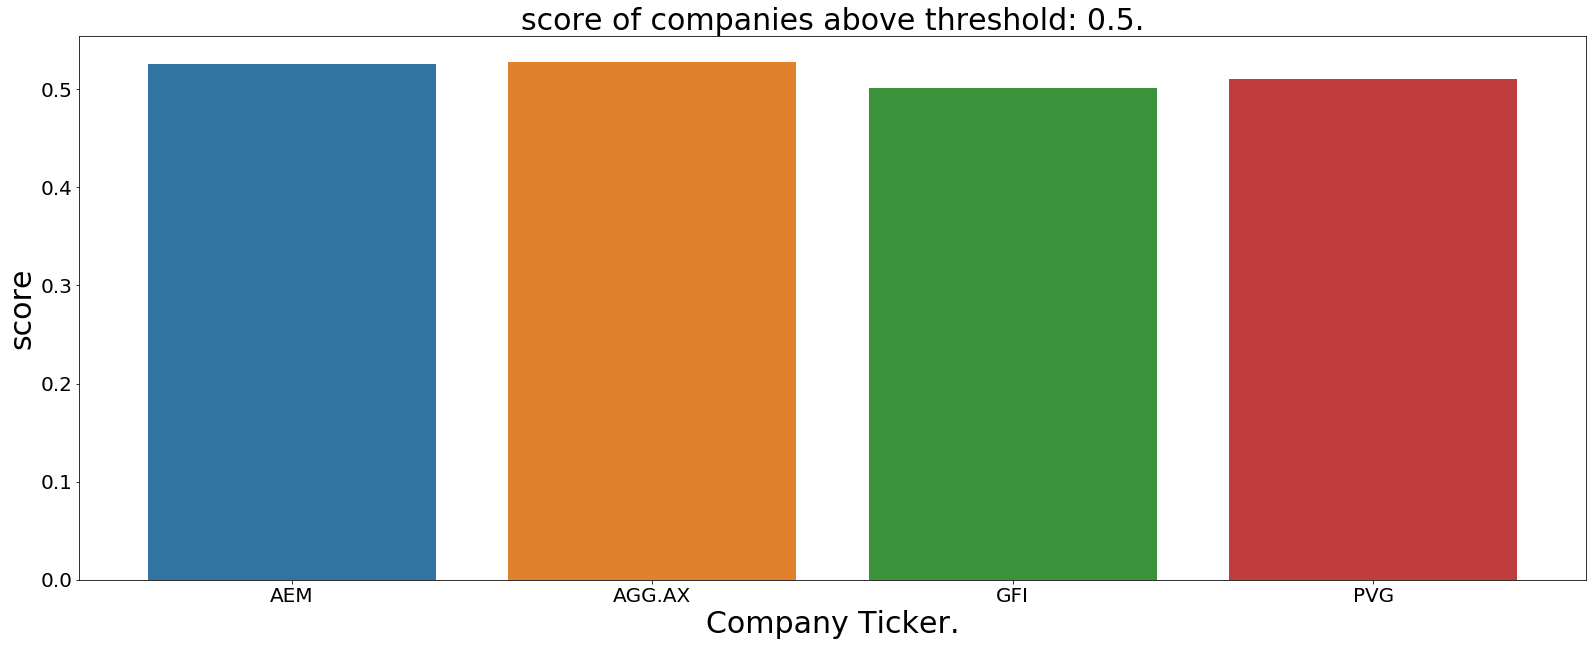

In [40]:
plotGraphOfMetricAboveAverage("score", tickerData, 0.5)

/home/kane/.local/share/virtualenvs/stock-screener-tEUH_GjD/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


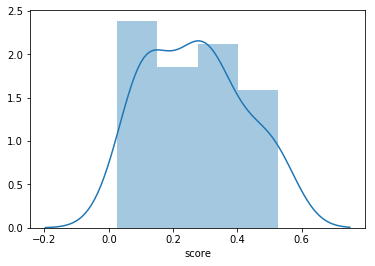

In [41]:
sns.distplot(tickerData["score"])
plt.show()